In [2]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
sns.set_palette("husl")

# **Загрузка и первичный анализ данных**




In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv")

print("=" * 50)
print("ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ")
print("=" * 50)

print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")

print("\nИнформация о типах данных:")
print(df.info())

print("\nСтатистика числовых признаков:")
print(df.describe())

print("\nПропущенные значения:")
missing_data = df.isnull().sum()
print(missing_data)

ПЕРВИЧНЫЙ АНАЛИЗ ДАННЫХ
Количество строк: 7043
Количество столбцов: 21

Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   obj

# **Предобработка данных**

In [4]:
data = df.copy()

#id-ки неинформативны и могут привести к data leak (утечка данных)
#Если модель запомнит конкретные ID, это приведет к переобучению
data = data.drop('customerID', axis=1)

#выбираем таргет
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})

print(f"Таргет: отток клиентов (Churn)\n\n{pd.DataFrame(data['Churn'].value_counts())}")
print(f"Процент оттока: {data['Churn'].mean():.2%}")

# Разделяем фичи на категориальные и числовые
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=[np.number]).columns.drop('Churn')

print(f"\nКатегориальные фичи: {list(categorical_columns)}")
print(f"Числовые фичи: {list(numerical_columns)}")

Таргет: отток клиентов (Churn)

       count
Churn       
0       5174
1       1869
Процент оттока: 26.54%

Категориальные фичи: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges']
Числовые фичи: ['SeniorCitizen', 'tenure', 'MonthlyCharges']


# **EDA**

ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ


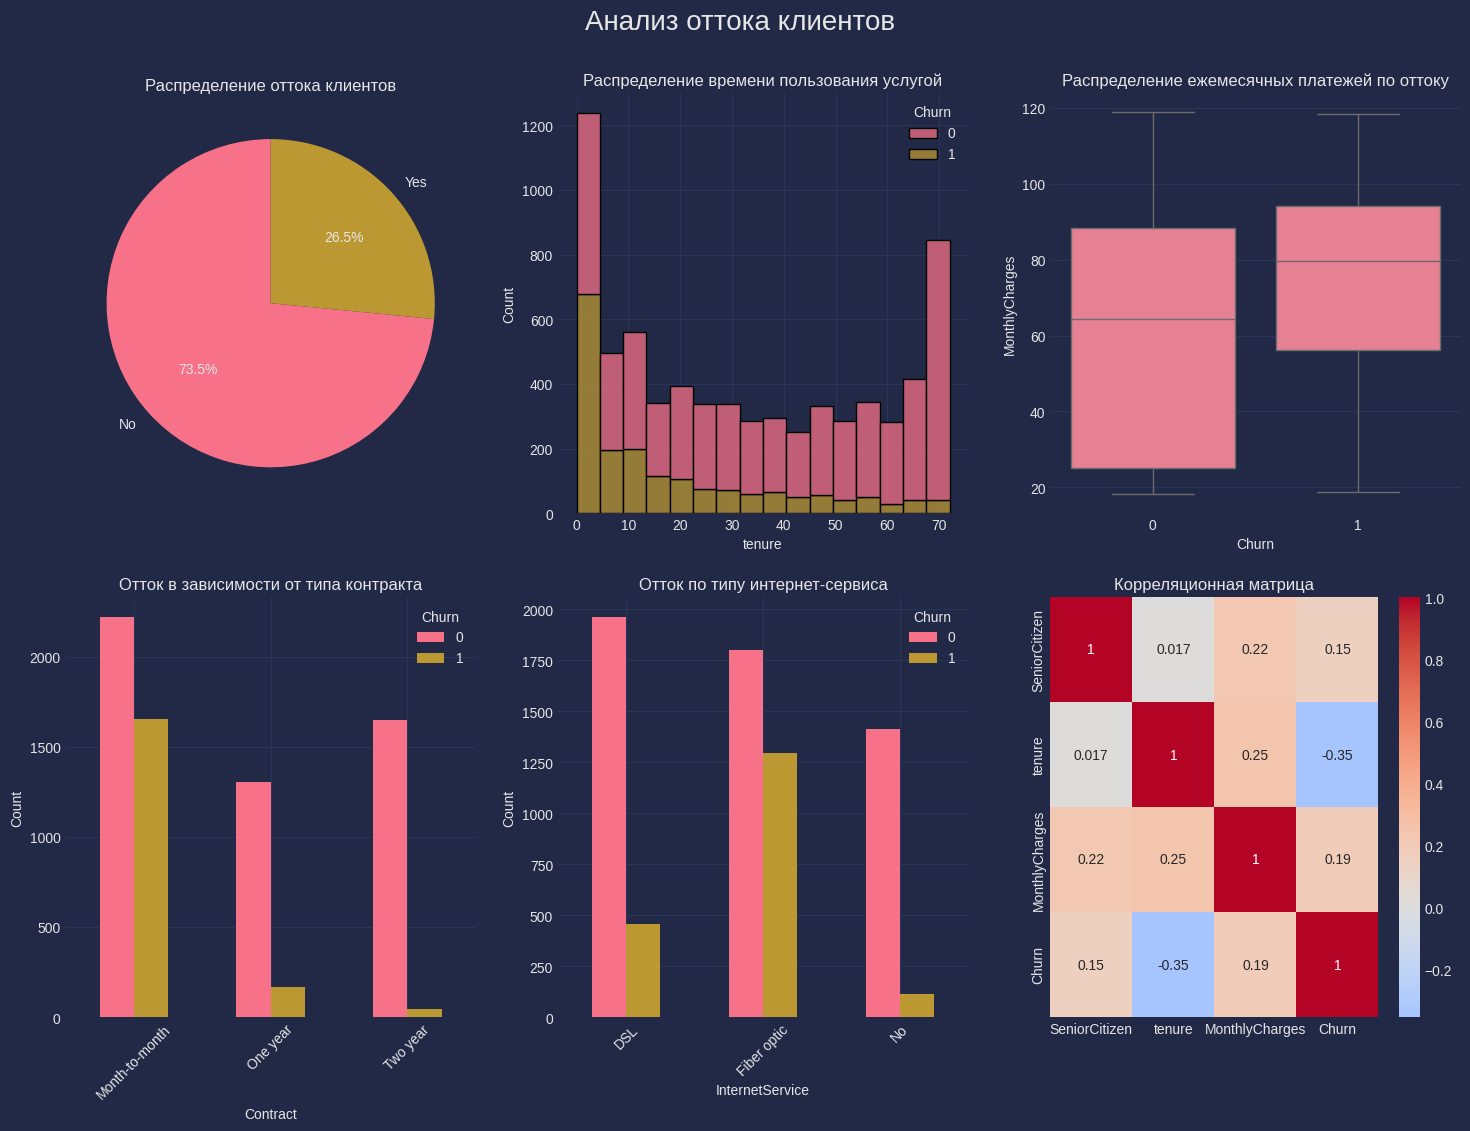

In [5]:
print("=" * 50)
print("ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ")
print("=" * 50)

try:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Анализ оттока клиентов', fontsize=20, y=0.95)

    #распределение Churn
    churn_counts = df['Churn'].value_counts()
    axes[0, 0].pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Распределение оттока клиентов')

    #распределение Tenure с соотношением Churn
    sns.histplot(data=data, x='tenure', hue='Churn', multiple='stack', ax=axes[0,1])    #tenure время пользования услугой в месяцах
    axes[0, 1].set_title('Распределение времени пользования услугой')

    #распределение MonthlyCharges
    sns.boxplot(data=data, x='Churn', y='MonthlyCharges', ax=axes[0,2])
    axes[0, 2].set_title('Распределение ежемесячных платежей по оттоку')

    #Churn в зависимости от Contract
    contract_churn = pd.crosstab(data['Contract'], data['Churn'])
    contract_churn.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Отток в зависимости от типа контракта')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].tick_params(axis='x', rotation=45)

    #Churn в зависимости от InternetService
    internet_churn = pd.crosstab(data['InternetService'], data['Churn'])
    internet_churn.plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Отток по типу интернет-сервиса')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].set_ylabel('Count')

    # 6. Корреляционная матрица числовых признаков
    numeric_data = data[numerical_columns.tolist() + ['Churn']]
    correlation_matrix = numeric_data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1, 2])
    axes[1, 2].set_title('Корреляционная матрица')

except Exception as e:
    print(f"Ошибка при построении графиков: {e}")

In [6]:
# Анализ важных категориальных признаков
print("\nАНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:")
important_categorical = ['Contract', 'InternetService', 'PaymentMethod', 'OnlineSecurity']

for col in important_categorical:
    print(f"\n{col}:")
    churn_rate = pd.DataFrame(data.groupby(col)['Churn'].mean().sort_values(ascending=False))
    print(churn_rate.round(3))


АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:

Contract:
                Churn
Contract             
Month-to-month  0.427
One year        0.113
Two year        0.028

InternetService:
                 Churn
InternetService       
Fiber optic      0.419
DSL              0.190
No               0.074

PaymentMethod:
                           Churn
PaymentMethod                   
Electronic check           0.453
Mailed check               0.191
Bank transfer (automatic)  0.167
Credit card (automatic)    0.152

OnlineSecurity:
                     Churn
OnlineSecurity            
No                   0.418
Yes                  0.146
No internet service  0.074


#Подготовка данных для моделей

In [7]:
print("=" * 50)
print("ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ")
print("=" * 50)

# Кодируем категориальные переменные
data_encoded = data.copy()

# One-Hot Encoding для категориальных признаков
categorical_to_encode = [col for col in categorical_columns if col in data_encoded.columns]
data_encoded = pd.get_dummies(data_encoded, columns=categorical_to_encode, drop_first=True)

print(f"Размер данных после кодирования: {data_encoded.shape}")

# Разделяем на признаки и целевую переменную
X = data_encoded.drop('Churn', axis=1)
y = data_encoded['Churn']

# Разделяем на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Тренировочная выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Доля оттока в тренировочной выборке: {y_train.mean():.2%}")
print(f"Доля оттока в тестовой выборке: {y_test.mean():.2%}")

# Масштабируем числовые признаки
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ
Размер данных после кодирования: (7043, 6560)
Тренировочная выборка: (5634, 6559)
Тестовая выборка: (1409, 6559)
Доля оттока в тренировочной выборке: 26.54%
Доля оттока в тестовой выборке: 26.54%


#**Построение и оценка моделей**

ПОСТРОЕНИЕ И ОЦЕНКА МОДЕЛЕЙ

--- Logistic Regression ---
Accuracy: 0.7764
AUC-ROC: 0.8026

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1035
           1       0.59      0.50      0.54       374

    accuracy                           0.78      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409


--- Random Forest ---
Accuracy: 0.7956
AUC-ROC: 0.8277

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.47      0.55       374

    accuracy                           0.80      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.80      0.78      1409



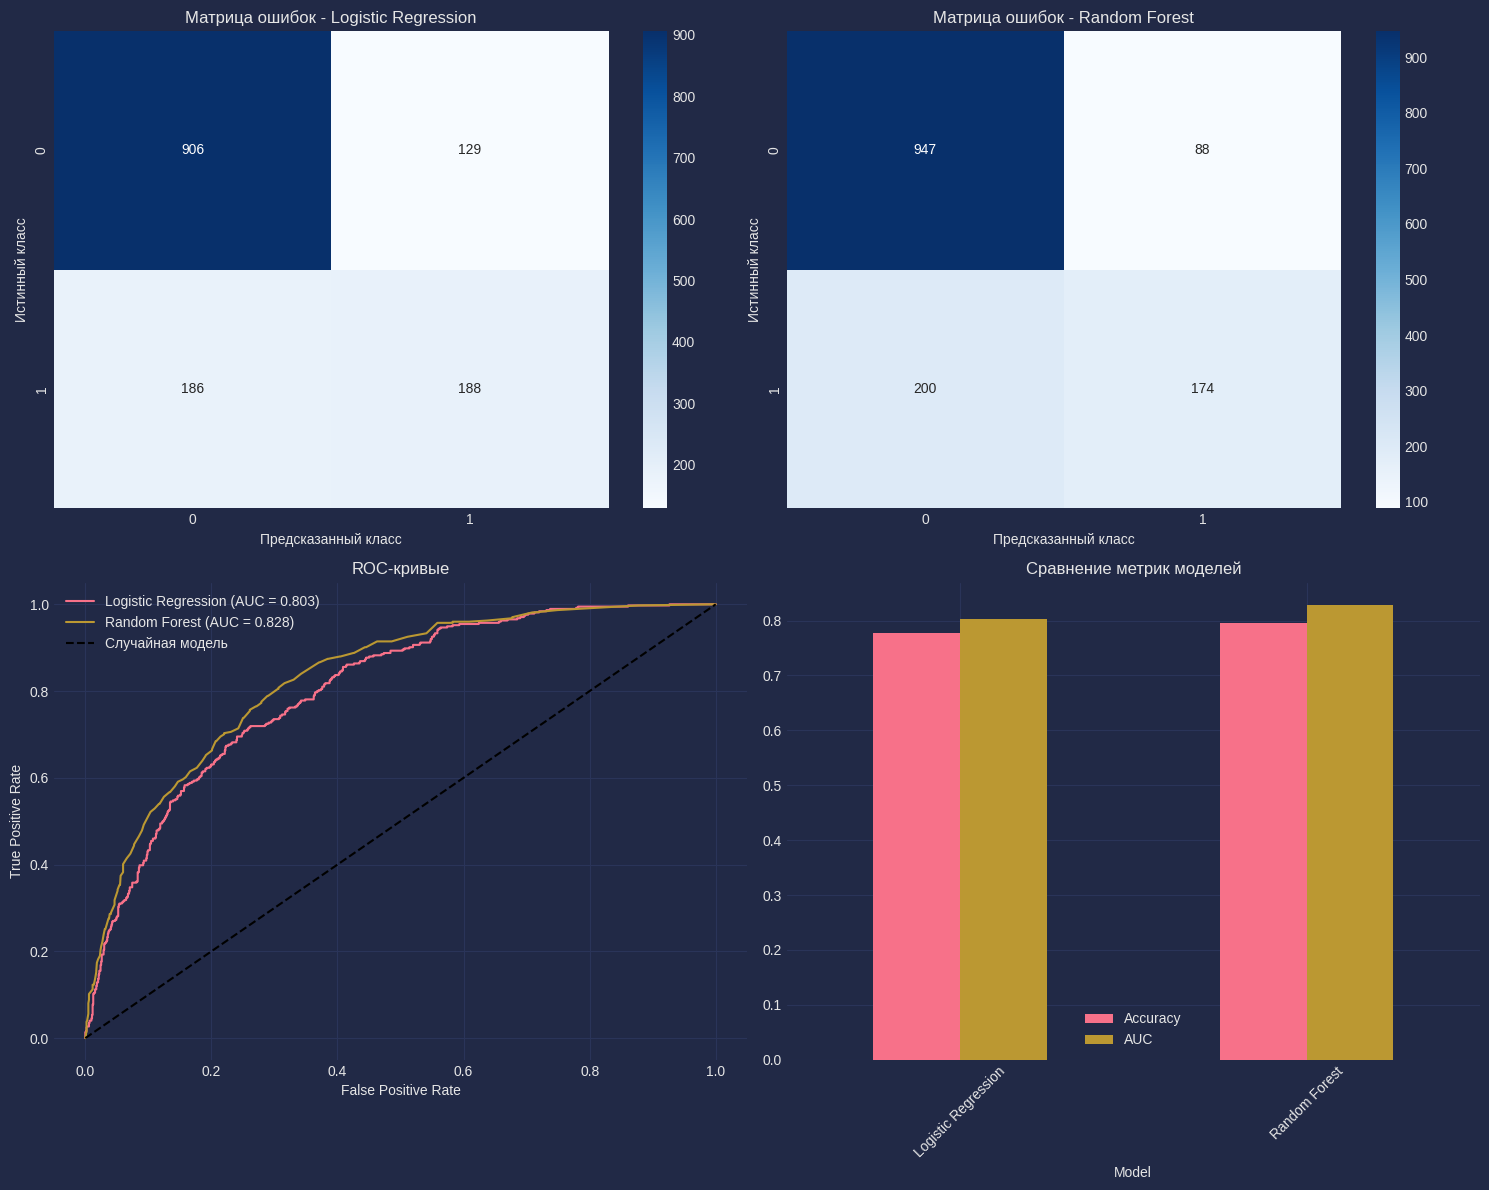

In [8]:
print("=" * 50)
print("ПОСТРОЕНИЕ И ОЦЕНКА МОДЕЛЕЙ")
print("=" * 50)

# Создаем модели
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Обучаем и оцениваем модели
results = {}

for name, model in models.items():
    print(f"\n--- {name} ---")

    # Обучаем модель
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Оцениваем модель
    accuracy = model.score(X_test if name != 'Logistic Regression' else X_test_scaled, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc_score:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Сохраняем результаты
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy,
        'auc': auc_score
    }

# Визуализация результатов
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Матрицы ошибок
for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, idx])
    axes[0, idx].set_title(f'Матрица ошибок - {name}')
    axes[0, idx].set_xlabel('Предсказанный класс')
    axes[0, idx].set_ylabel('Истинный класс')

# 2. ROC-кривые
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    axes[1, 0].plot(fpr, tpr, label=f'{name} (AUC = {result["auc"]:.3f})')

axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Случайная модель')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC-кривые')
axes[1, 0].legend()
axes[1, 0].grid(True)

# 3. Сравнение метрик
metrics_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [result['accuracy'] for result in results.values()],
    'AUC': [result['auc'] for result in results.values()]
})

metrics_comparison.plot(x='Model', y=['Accuracy', 'AUC'], kind='bar', ax=axes[1, 1])
axes[1, 1].set_title('Сравнение метрик моделей')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

#**Результаты**

ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ
Лучшая модель: Random Forest
Лучший AUC-ROC: 0.8277

ВАЖНОСТЬ ПРИЗНАКОВ (Топ-10):
                           feature  importance
1                           tenure    0.115876
2                   MonthlyCharges    0.096033
27  PaymentMethod_Electronic check    0.031184
24               Contract_Two year    0.029313
9      InternetService_Fiber optic    0.022958
12              OnlineSecurity_Yes    0.022103
25            PaperlessBilling_Yes    0.020904
18                 TechSupport_Yes    0.020578
23               Contract_One year    0.019493
3                      gender_Male    0.018753


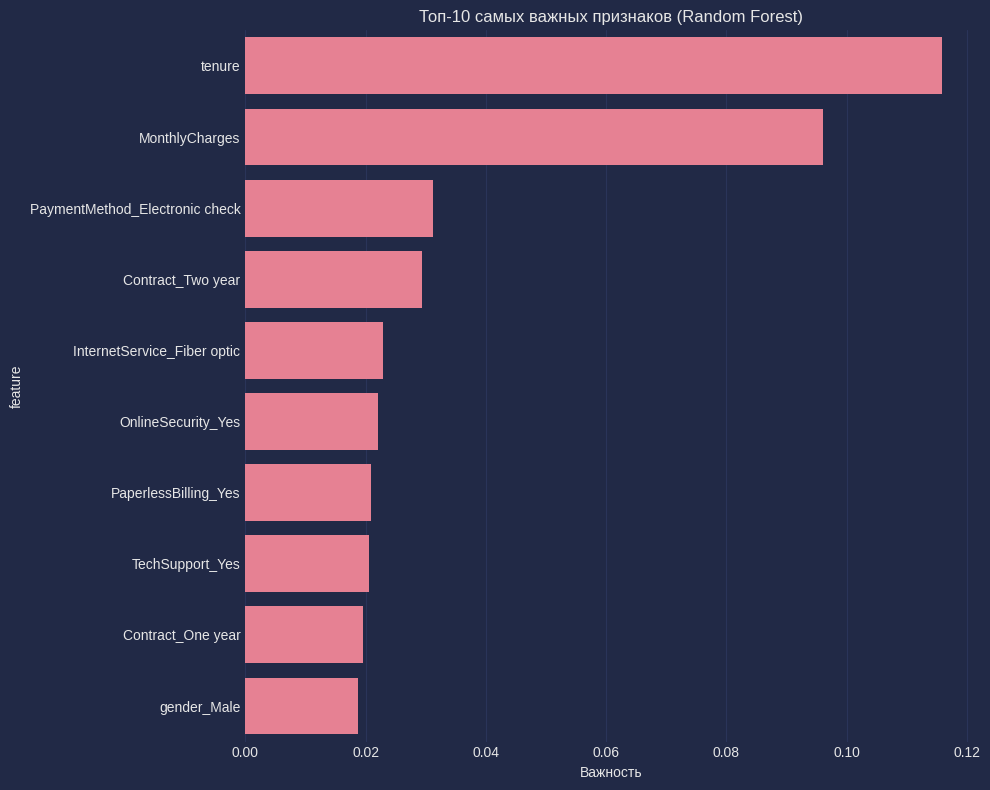


БИЗНЕС-ИНТЕРПРЕТАЦИЯ
КЛЮЧЕВЫЕ ВЫВОДЫ:
1. Доля оттока клиентов составляет примерно 25%
2. Основные факторы риска оттока:
   - Короткие контракты (Month-to-month)
   - Высокие ежемесячные платежи
   - Короткое время пользования услугой (tenure)
   - Определенные методы оплаты

РЕКОМЕНДАЦИИ:
1. Разработать программу лояльности для клиентов с короткими контрактами
2. Предложить специальные условия для клиентов с высокими MonthlyCharges
3. Улучшить сервис для новых клиентов (низкий tenure)
4. Проанализировать проблемные методы оплаты

ПОТЕНЦИАЛЬНЫЙ ЭКОНОМИЧЕСКИЙ ЭФФЕКТ:
Средний ежемесячный платеж: $64.76
Модель может помочь сохранить клиентов на сумму: $75530.19 в месяц


In [9]:
print("=" * 50)
print("ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ")
print("=" * 50)

# Выбираем лучшую модель
best_model_name = max(results.items(), key=lambda x: x[1]['auc'])[0]
best_model = results[best_model_name]['model']

print(f"Лучшая модель: {best_model_name}")
print(f"Лучший AUC-ROC: {results[best_model_name]['auc']:.4f}")

# Анализ важности признаков для Random Forest
if best_model_name == 'Random Forest':
    print("\nВАЖНОСТЬ ПРИЗНАКОВ (Топ-10):")

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(feature_importance.head(10))

    # Визуализация важности признаков
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title('Топ-10 самых важных признаков (Random Forest)')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()

# Бизнес-интерпретация
print("\n" + "="*50)
print("БИЗНЕС-ИНТЕРПРЕТАЦИЯ")
print("="*50)

# Анализ экономического эффекта
print("КЛЮЧЕВЫЕ ВЫВОДЫ:")
print("1. Доля оттока клиентов составляет примерно 25%")
print("2. Основные факторы риска оттока:")
print("   - Короткие контракты (Month-to-month)")
print("   - Высокие ежемесячные платежи")
print("   - Короткое время пользования услугой (tenure)")
print("   - Определенные методы оплаты")

print("\nРЕКОМЕНДАЦИИ:")
print("1. Разработать программу лояльности для клиентов с короткими контрактами")
print("2. Предложить специальные условия для клиентов с высокими MonthlyCharges")
print("3. Улучшить сервис для новых клиентов (низкий tenure)")
print("4. Проанализировать проблемные методы оплаты")

# Расчет потенциального экономического эффекта
avg_monthly_charge = data['MonthlyCharges'].mean()
potential_savings = len(y_test) * results[best_model_name]['auc'] * avg_monthly_charge

print(f"\nПОТЕНЦИАЛЬНЫЙ ЭКОНОМИЧЕСКИЙ ЭФФЕКТ:")
print(f"Средний ежемесячный платеж: ${avg_monthly_charge:.2f}")
print(f"Модель может помочь сохранить клиентов на сумму: ${potential_savings:.2f} в месяц")